In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

добавляем нашу таблицу, суммируем ее по дням

In [4]:
data = pd.read_csv('Daily_Humidity.csv', index_col = [0], parse_dates=[0])
data = data.resample('1D').sum()
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2014-01-01 to 2016-12-31
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   humidity  1096 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB


,humidity
date,
2014-01-01,89.625
2014-01-02,78.375
2014-01-03,74.875
2014-01-04,88.125
2014-01-05,89.000


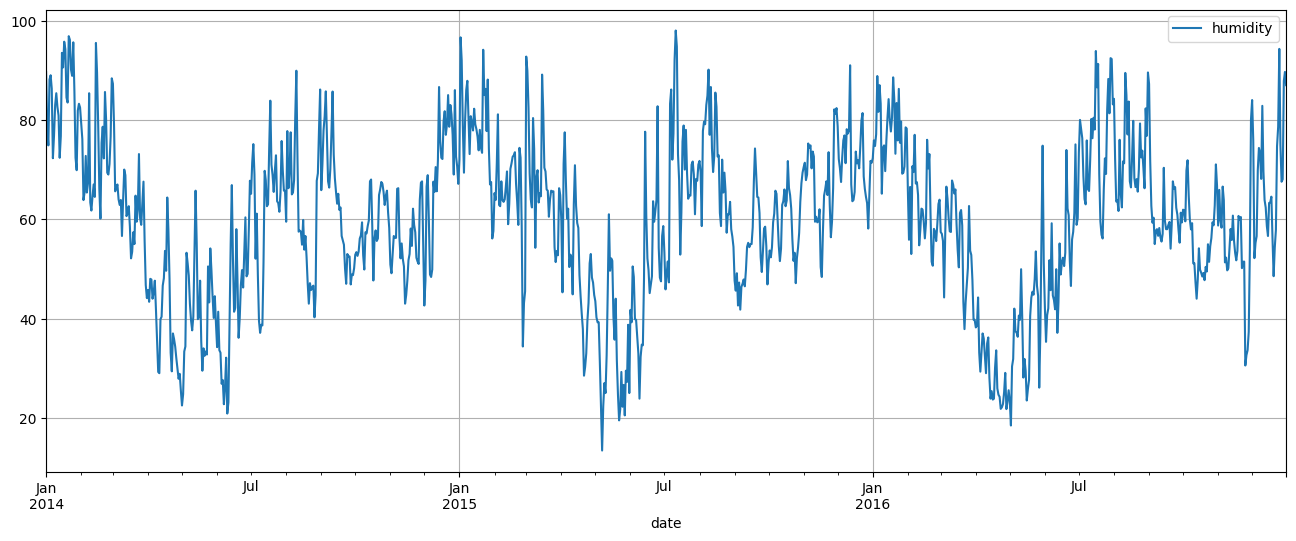

In [5]:
data['2014-01-01':'2016-12-31'].plot(figsize=(16,6), 
                                       grid=True, 
                                       )
plt.show()

In [6]:
# создаем признаки

data_copy = data.copy()

for lag in range(1, 50):
    data_copy[f'lag_{lag}'] = data_copy['humidity'].shift(lag)

data_copy = data_copy.dropna()
data_copy

,humidity,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49
date,,,,,,,,,,,,,,,,,,,,,
2014-02-19,75.375000,60.125000,66.125000,79.000000,89.500000,95.500000,64.500000,67.000000,64.625000,61.750000,...,85.375000,83.000000,76.875000,72.285714,86.285714,89.000000,88.125000,74.875000,78.375000,89.625000
2014-02-20,78.625000,75.375000,60.125000,66.125000,79.000000,89.500000,95.500000,64.500000,67.000000,64.625000,...,82.625000,85.375000,83.000000,76.875000,72.285714,86.285714,89.000000,88.125000,74.875000,78.375000
2014-02-21,72.250000,78.625000,75.375000,60.125000,66.125000,79.000000,89.500000,95.500000,64.500000,67.000000,...,80.875000,82.625000,85.375000,83.000000,76.875000,72.285714,86.285714,89.000000,88.125000,74.875000
2014-02-22,85.625000,72.250000,78.625000,75.375000,60.125000,66.125000,79.000000,89.500000,95.500000,64.500000,...,72.375000,80.875000,82.625000,85.375000,83.000000,76.875000,72.285714,86.285714,89.000000,88.125000
2014-02-23,80.000000,85.625000,72.250000,78.625000,75.375000,60.125000,66.125000,79.000000,89.500000,95.500000,...,76.750000,72.375000,80.875000,82.625000,85.375000,83.000000,76.875000,72.285714,86.285714,89.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,67.550000,74.857143,94.300000,78.636364,74.700000,57.857143,54.300000,48.533333,56.095238,64.541667,...,51.730769,53.230769,55.720000,60.730769,55.814815,58.038462,54.040000,50.148148,49.703704,52.269231
2016-12-28,68.043478,67.550000,74.857143,94.300000,78.636364,74.700000,57.857143,54.300000,48.533333,56.095238,...,53.615385,51.730769,53.230769,55.720000,60.730769,55.814815,58.038462,54.040000,50.148148,49.703704
2016-12-29,87.857143,68.043478,67.550000,74.857143,94.300000,78.636364,74.700000,57.857143,54.300000,48.533333,...,60.666667,53.615385,51.730769,53.230769,55.720000,60.730769,55.814815,58.038462,54.040000,50.148148


In [7]:
# разбиваем на выборки
train, test = train_test_split(data_copy, shuffle=False, test_size=0.02
                            )
train_features = train.drop('humidity', axis=1)
train_target = train['humidity']

test_features = test.drop('humidity', axis=1)
test_target = test['humidity']

далее строим  модель авторегрессии с рекурентной стратегией, для примера ставлю 50 лагов для всех стратегий. На самом деле, я уже знаю, что когда лаги увеличатся, результат будет хороший.

In [8]:
model = LinearRegression()
model.fit(train_features, train_target)
       
predictions_1 = pd.DataFrame(columns=['humidity'], index=test_target.index)
x_test = test_features.iloc[[0]]

for i in range(len(test_features)):

    y_pred = model.predict(x_test)
    predictions_1.iloc[i] = y_pred
    
    if i < len(test_features) - 1:  
        x_test.iloc[0, 1:] = x_test.iloc[0, :-1].values  
        x_test.iloc[0, 0] = y_pred[0]  

mape = mean_absolute_percentage_error(test_target, predictions_1)
r2 = r2_score(test_target, predictions_1)

print('\033[1mMape на тестовой выборке:\033[0m ', mape, 
      '\n\033[1mR2 на тестовой выборке:\033[0m ', r2)

Mape на тестовой выборке:  0.1673295182923949 
R2 на тестовой выборке:  -0.2247667203139807


строим модель авторегрессии с прямой стратегией

In [9]:
model = LinearRegression()


predictions_2 = pd.DataFrame(columns=['humidity'], index=test_target.index)
x_train = train_features
y_train = train_target
x_test = test_features.iloc[[0]]
    
for i in range(len(test_features)):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    predictions_2.iloc[i] = y_pred
    
    y_train = y_train.shift(-1).dropna()
    x_train = x_train[:-1]
    
mape = mean_absolute_percentage_error(test_target, predictions_2)
r2 = r2_score(test_target, predictions_2)

print('\033[1mmape на тестовой выборке:\033[0m ', mape, 
      '\n\033[1mR2 на тестовой выборке:\033[0m ', r2)

mape на тестовой выборке:  0.1680945988666768 
R2 на тестовой выборке:  -0.24261671731683498


строим модель авторегрессии с гибридной стратегией

In [10]:
model = LinearRegression()

predictions_3 = pd.DataFrame(columns=['humidity'], index=test_target.index)
x_train = train_features
y_train = train_target
x_test = test_features.iloc[[0]]


for i in range(len(test_features)):
    model.fit(train_features, train_target)

    
    y_pred = model.predict(x_test)
    predictions_3.iloc[i] = y_pred
    
    for i in range(len(test_features)):
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        predictions_3.iloc[i] = y_pred
    
        y_train = y_train.shift(-1).dropna()
        x_train = x_train[:-1]
    
    if i < len(test_features) - 1:  
        x_test.iloc[0, 1:] = x_test.iloc[0, :-1].values  
        x_test.iloc[0, 0] = y_pred[0]  

mape = mean_absolute_percentage_error(test_target, predictions_3)
r2 = r2_score(test_target, predictions_3)

print('\033[1mmape на тестовой выборке:\033[0m ', mape, 
      '\n\033[1mR2 на тестовой выборке:\033[0m ', r2)

mape на тестовой выборке:  0.16479883020518052 
R2 на тестовой выборке:  -1.1116349403038823


построим графики предсказаний. на самом деле результаты не очень хорошие, но мы делаем это на маленьких лагах, и все, что нам надо понять- какая стратегия будет лучше всего, лучше всего показала себя рекурентная стратегия, ее и возьмем для проверки модели на разных лагах

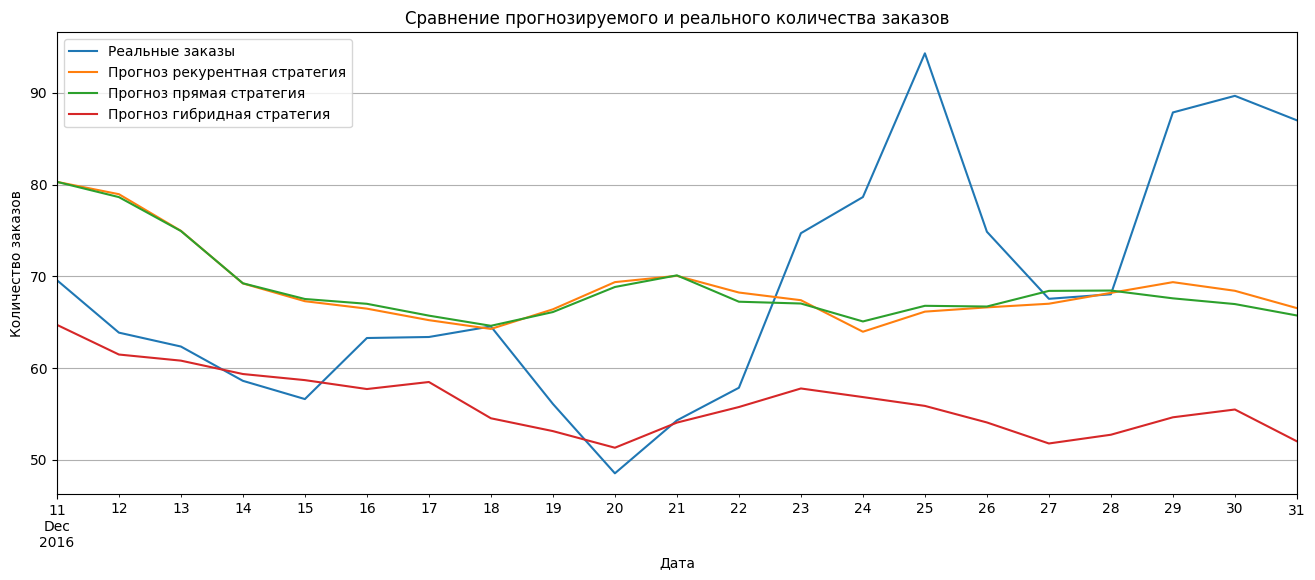

In [11]:
data_pred = pd.DataFrame({'test': test_target, 
                          'pred 1': predictions_1['humidity'],
                          'pred 2': predictions_2['humidity'],
                          'pred 3': predictions_3['humidity']}, 
                          index=test_target.index) 
data_pred.plot(figsize=(16,6), 
               grid=True,
               xlabel='Дата',
               ylabel='Количество заказов',
               title='Сравнение прогнозируемого и реального количества заказов')
plt.legend(['Реальные заказы', 
            'Прогноз рекурентная стратегия', 
            'Прогноз прямая стратегия', 
            'Прогноз гибридная стратегия'])
plt.show()

In [101]:
#создадим функцию формирования признаков
def make_features(df, max_lag):
    data_copy = df.copy()
    for lag in range(1, max_lag):
        data_copy[f'lag_{lag}'] = data.iloc[:, 0].shift(lag)

    data_copy = data_copy.dropna()
    return data_copy



In [110]:
model = LinearRegression()
max_lag = 500
best_max_lag = 0
best_score = 0

for lag in range(50, max_lag, 50):
    df = make_features(data, lag)
    
    train, test = train_test_split(df, shuffle=False, test_size=0.02)
    train_features = train.drop('humidity', axis=1)
    train_target = train['humidity']

    test_features = test.drop('humidity', axis=1)
    test_target = test['humidity']

    model.fit(train_features, train_target)
       
    predictions = pd.DataFrame(columns=['humidity'], index=test_target.index)
    x_test = test_features.iloc[[0]]

    for i in range(len(test_features)):
        y_pred = model.predict(x_test)
        predictions.iloc[i] = y_pred
        if i < len(test_features) - 1:  
            x_test.iloc[0, 1:] = x_test.iloc[0, :-1].values  
            x_test.iloc[0, 0] = y_pred[0]  
        
    r2 = r2_score(test_target, predictions)
    
    if r2 > best_score:
        best_score = r2
        best_mape = mean_absolute_percentage_error(test_target, predictions)
        best_max_lag = lag
        best_predictions = predictions


print('\033[1mMape на тестовой выборке:\033[0m ', best_mape, 
      '\n\033[1mR2 на тестовой выборке:\033[0m ', best_score,
     '\n\033[1mОптимальнное количество лагов:\033[0m ', best_max_lag)       

Mape на тестовой выборке:  0.08000321695878666 
R2 на тестовой выборке:  0.7289928798656873 
Оптимальнное количество лагов:  450


как мы видим, на более больших лагах рекурентая стратегия очень хорошо себя показала, мы добились более менее неплохого результата.

# Выводы:
### На самом деле над этой лабортарной работе я сидел гораздо дольше, чем может показаться по ее описанию. Я применял разные модели линейной регрессии, использовал кросс-валидацию, пытался найти лучшие параметры каждой модели к разным стратегиям, однако результат был очень плох. Огромное кол-во времени было потрачено на обработку (8 часов обрабатывался GradientBoosting с подбором параметров и кросс-валидацией в прямой стратегии, результат - -0.2). В данном случае LinearRegression действительно неплохо работает, особенно на рекурентной стратегией при переборе лагов.